# Automated Essay Scoring
Machine Learning Challenge by [Kaggle](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview)

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import keras
import keras_nlp
import tensorflow as tf

from textblob import TextBlob
import spacy
import language_tool_python
from sklearn.ensemble import RandomForestClassifier

2024-05-26 19:59:14.839744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if CUDA is available
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())


TensorFlow version: 2.16.1
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Built with GPU support: True


In [3]:
import tensorflow as tf
import time

# Create a large random matrix
matrix_size = 10000
a = tf.random.normal([matrix_size, matrix_size])
b = tf.random.normal([matrix_size, matrix_size])

# Perform matrix multiplication on GPU
start_time = time.time()
c = tf.matmul(a, b)
end_time = time.time()

print("Matrix multiplication result:", c)
print("Time taken (seconds):", end_time - start_time)


Matrix multiplication result: 

2024-05-26 19:59:22.972656: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 400000000 exceeds 10% of free system memory.


tf.Tensor(
[[  83.47854    -39.61264    163.99788   ...  -66.659454   -53.406597
    57.569996 ]
 [ -23.038761     9.587336   148.75148   ...   97.806595    79.19261
  -209.81839  ]
 [ -94.76154   -138.43788     94.30437   ...  140.49619     90.7986
    25.596941 ]
 ...
 [ -10.148516   211.88193    -78.86122   ...   39.20982    180.60562
   154.53346  ]
 [  17.477066     1.4067953  111.172745  ... -119.58943    -48.088894
    17.422588 ]
 [  80.66383     41.84781     35.399334  ...   71.169945    76.45945
   -72.439865 ]], shape=(10000, 10000), dtype=float32)
Time taken (seconds): 0.26294565200805664


## Small EDA

In [4]:
df = pd.read_csv('data/train.csv')

In [5]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [7]:
df.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [8]:
df.isna().sum()

essay_id     0
full_text    0
score        0
dtype: int64

In [9]:
df['score'].value_counts()

score
3    6280
2    4723
4    3926
1    1252
5     970
6     156
Name: count, dtype: int64

## Evaluation using the Quadratic Weighted Kappa
The quadratic weighted kappa (QWK) score ranges from -1 to 1. A score of 1 indicates perfect agreement between the predicted score and the true score. A score of 0 indicates the agreement is no better than random. A score of -1 indicates perfect disagreement between the predicted score and the true score.

In [10]:
def quadratic_weighted_kappa(y_true, y_pred, min_rating=None, max_rating=None):
    """
    Computes the quadratic weighted kappa.
    """
    if min_rating is None:
        min_rating = min(min(y_true), min(y_pred))
    if max_rating is None:
        max_rating = max(max(y_true), max(y_pred))

    conf_mat = confusion_matrix(y_true, y_pred, labels=range(min_rating, max_rating + 1))
    num_ratings = len(conf_mat)
    num_scored_items = float(len(y_true))

    hist_true = np.histogram(y_true, bins=np.arange(min_rating, max_rating + 2))[0]
    hist_pred = np.histogram(y_pred, bins=np.arange(min_rating, max_rating + 2))[0]

    expected_mat = np.outer(hist_true, hist_pred) / num_scored_items

    weight_mat = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            weight_mat[i, j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)

    kappa = 1.0 - (np.sum(weight_mat * conf_mat) / np.sum(weight_mat * expected_mat))
    return kappa

## Using CountVectorizer and TfidfTransformer from sklearn 
[Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

*Simple Text Preprocessing*

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='score'), df['score'], test_size=0.2, random_state=42)

In [12]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train['full_text'])
X_train_counts.shape

(13845, 56588)

Literally a word count but with tokens/chunks of texts. 

In [13]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(13845, 56588)

TfidfTransformer is used to convert the word count into a frequency matrix. We simply divide the number of word per document/data/observation by total number of this word in all documents.

In [14]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [15]:
X_new_counts = count_vect.transform(X_test['full_text'])
X_new_counts

<3462x56588 sparse matrix of type '<class 'numpy.int64'>'
	with 564659 stored elements in Compressed Sparse Row format>

In [16]:
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
X_new_tfidf

<3462x56588 sparse matrix of type '<class 'numpy.float64'>'
	with 564659 stored elements in Compressed Sparse Row format>

In [17]:
predicted = clf.predict(X_new_tfidf)
predicted

array([3, 3, 3, ..., 3, 3, 3])

In [18]:
pred_df = pd.DataFrame({'essay_id': X_test['essay_id'], 'full_text': X_test['full_text'], 'score': predicted})
pred_df

,essay_id,full_text,score
12696,bb4c434,"People tend to use there cars so much, they ba...",3
4625,44e88b0,Imagine being a top scientist at NASA and Viki...,3
733,0ba78ec,The face of Mars could not be created by alien...,3
16885,f96c287,Many people belive that the face on Mars was c...,3
3334,317173f,Driverless Cars are coming soon or later? Peop...,3
...,...,...,...
16145,ee1d27b,How the author support his suggests that study...,3
4229,3e7dd0b,"In this aricle , the author its trying to you ...",3
4313,3fdbec2,The Facial Action Coding System enables comput...,3
934,0edee1b,"Hello my name is Luke Bomberger and, welcome t...",3


In [19]:
print(f"Mean: {np.mean(predicted == y_test)}")

Mean: 0.3694396302715193


In [20]:
kappa_score = quadratic_weighted_kappa(y_test, predicted)
print(f"Quadratic Weighted Kappa: {kappa_score}")

Quadratic Weighted Kappa: 0.034102332855281525


In [21]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train['full_text'], y_train)
predicted = text_clf.predict(X_test['full_text'])

print(f"Mean: {np.mean(predicted == y_test)}")

kappa_score = quadratic_weighted_kappa(y_test, predicted)
print(f"Quadratic Weighted Kappa: {kappa_score}")

Mean: 0.4679376083188908
Quadratic Weighted Kappa: 0.5708430116379231


Not so bad, getting a score of 0.57

## Using [NLTK](https://www.nltk.org/)
Following [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)
<br/>
Some [documentation](https://datascientest.com/nlp-word-embedding-word2vec) 

### Model with some text preprocessing 
- lowercase, strip and remove punctuations
- stopwords
- Lemmatizer

In [22]:
df_nltk = pd.read_csv('data/train.csv')

In [23]:
df_nltk.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [24]:
# For text preprocessing

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jacq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jacq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jacq/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jacq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [26]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_nltk['clean_text'] = df_nltk['full_text'].apply(lambda x: finalpreprocess(x))
df_nltk.head()

,essay_id,full_text,score,clean_text
0,000d118,Many people have car where they live. The thin...,3,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,3,scientist nasa discuss face mar explain face l...
2,001ab80,People always wish they had the same technolog...,4,people always wish technology see movie best n...
3,001bdc0,"We all heard about Venus, the planet without a...",4,heard venus planet without almost oxygen earth...
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,dear state senator letter argue favor keep ele...


In [27]:
X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(df_nltk.drop(columns='score'), df_nltk['score'], test_size=0.2, random_state=42)

In [28]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True) # WordVectorizer and TfidfTransformer in one model
X_train_nltk_tfidf = tfidf_vectorizer.fit_transform(X_train_nltk['clean_text'])
X_test_nltk_tfidf = tfidf_vectorizer.transform(X_test_nltk['clean_text'])

In [29]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, random_state=42,
                    max_iter=5, tol=None)

clf.fit(X_train_nltk_tfidf, y_train_nltk)
predicted = clf.predict(X_test_nltk_tfidf)

print(f"Mean: {np.mean(predicted == y_test_nltk)}")

kappa_score = quadratic_weighted_kappa(y_test_nltk, predicted)
print(f"Quadratic Weighted Kappa: {kappa_score}")

Mean: 0.45031773541305603
Quadratic Weighted Kappa: 0.5574675462818004


The text preprocessing made it slightly worse than before.  

### With word vectorization

In [30]:
# Tokenize the sentences
X_train_nltk['clean_text_tok'] = X_train_nltk['full_text'].apply(nltk.word_tokenize)
X_train_nltk.head()

,essay_id,full_text,clean_text,clean_text_tok
12931,be29f81,There is no question that the driverless car i...,question driverless car technological advancem...,"[There, is, no, question, that, the, driverles..."
12955,be96267,"I will be telling you about a story called ""A ...",tell story call cowboy rode wave think good st...,"[I, will, be, telling, you, about, a, story, c..."
4410,417a337,While driveless cars a cooler driving yourself...,driveless car cooler drive may bite safe every...,"[While, driveless, cars, a, cooler, driving, y..."
15013,dcf3a1e,"Dear State Senator,\r\n\r\nI do not like the E...",dear state senator like electoral college elec...,"[Dear, State, Senator, ,, I, do, not, like, th..."
10643,9d04b4e,"The "" Unmasking the Face on Mars"" was NOT crea...",unmask face mar create alien face mar natural ...,"[The, ``, Unmasking, the, Face, on, Mars, '', ..."


In [31]:
X_test_nltk['clean_text_tok'] = X_test_nltk['full_text'].apply(nltk.word_tokenize)
X_test_nltk.head()

,essay_id,full_text,clean_text,clean_text_tok
12696,bb4c434,"People tend to use there cars so much, they ba...",people tend use car much basically live get da...,"[People, tend, to, use, there, cars, so, much,..."
4625,44e88b0,Imagine being a top scientist at NASA and Viki...,imagine top scientist nasa viking spacecraft s...,"[Imagine, being, a, top, scientist, at, NASA, ..."
733,0ba78ec,The face of Mars could not be created by alien...,face mar could create alien land form create c...,"[The, face, of, Mars, could, not, be, created,..."
16885,f96c287,Many people belive that the face on Mars was c...,many people belive face mar create alien alien...,"[Many, people, belive, that, the, face, on, Ma..."
3334,317173f,Driverless Cars are coming soon or later? Peop...,driverless car come soon later people argue po...,"[Driverless, Cars, are, coming, soon, or, late..."


In [32]:
#building Word2Vec model

model = Word2Vec(sentences=X_train_nltk['clean_text_tok'], 
                 vector_size=100, 
                 window=5, 
                 min_count=1, 
                 workers=4
                 )
w2v = {word: vector for word, vector in zip(model.wv.index_to_key, model.wv.vectors)}

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0) for words in X
        ])

In [33]:
modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_nltk['clean_text_tok'])
X_test_vectors_w2v = modelw.transform(X_test_nltk['clean_text_tok'])

In [34]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, random_state=42,
                    max_iter=5, tol=None)

clf.fit(X_train_vectors_w2v, y_train_nltk)
predicted = clf.predict(X_test_vectors_w2v)

print(f"Mean: {np.mean(predicted == y_test_nltk)}")

kappa_score = quadratic_weighted_kappa(y_test_nltk, predicted)
print(f"Quadratic Weighted Kappa: {kappa_score}")

Mean: 0.3922588099364529
Quadratic Weighted Kappa: 0.32870141660655017


Something went seriously wrong here... 

## NLP with [Keras pretrained models](https://keras.io/api/keras_nlp/models/#kerasnlp-models)

[Bert Classifiers](https://keras.io/api/keras_nlp/models/bert/bert_classifier/)

### Tiny [Bert](https://keras.io/api/keras_nlp/models/bert/bert_classifier/) uncased : 4.9M parameters

In [41]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_tiny_en_uncased")
classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=7, preprocessor=None)

In [35]:
# Convert to TensorFlow dataset
def dataframe_to_dataset(X, y):
    df = X.copy()
    df['labels'] = y
    ds = tf.data.Dataset.from_tensor_slices((dict(df)))
    return ds

train_tf_dataset = dataframe_to_dataset(X_train_nltk[['clean_text']], y_train)
test_tf_dataset = dataframe_to_dataset(X_test_nltk[['clean_text']], y_test)

In [36]:
def get_texts_and_labels(X, y):
    texts = X['clean_text'].tolist()
    labels = y.tolist()
    return texts, labels

train_texts, train_labels = get_texts_and_labels(X_train_nltk[['clean_text']], y_train)
test_texts, test_labels = get_texts_and_labels(X_test_nltk[['clean_text']], y_test)

print((train_texts[0], train_labels[0]))

('question driverless car technological advancement today society however importanat question yet completely answered question full use driverless car necessary technological advancement answer yes important question driverless car necessary technological advancement first reason infinite possibility taht driverless car offer would benefit society second reason safety driverless car could offer complete fully reason support driverless car could benefit society many way technological advancement driverless car necessary one would benefit society developmentment driverless car would offer infinite possiblities would provide many important benefit one benefit driver would ability rest relax may argue driver never rest relax wheel however driverless car completely develop wouldnt need driver car drive driver relaxes well alternative tire sriver also mention passage every car driverless transportation efficiency speed would excel every fleet car system transportation would efficient flawles

In [42]:
# Preprocess the texts 
# The preprocessor will tokenize the texts, and encode them into ids to map to the BERT vocabulary
preprocessed_train_texts = preprocessor(train_texts)
preprocessed_test_texts = preprocessor(test_texts)

In [43]:
classifier.fit(x=preprocessed_train_texts, y=train_labels, batch_size=2)

I0000 00:00:1716747267.001751   22811 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_83', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716747272.630676   22819 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_83', 1488 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1716747276.647152   22813 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 8 bytes spill stores, 8 bytes spill loads



6921/6923 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2083 - sparse_categorical_accuracy: 0.5184

I0000 00:00:1716747417.143867   23862 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14', 40 bytes spill stores, 56 bytes spill loads

I0000 00:00:1716747421.033782   23858 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24', 168 bytes spill stores, 160 bytes spill loads

I0000 00:00:1716747421.052149   23863 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716747421.347801   23857 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1716747421.873269   23860 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 40 bytes spill stores, 56 bytes spill loads

I0000 00:00:1716747422.399524   23866 as

6923/6923 ━━━━━━━━━━━━━━━━━━━━ 194s 22ms/step - loss: 1.2082 - sparse_categorical_accuracy: 0.5184


In [44]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)
classifier.fit(x=preprocessed_train_texts, y=train_labels, batch_size=2)

6923/6923 ━━━━━━━━━━━━━━━━━━━━ 92s 11ms/step - loss: 0.8884 - sparse_categorical_accuracy: 0.6230


In [45]:
predictions = classifier.predict(preprocessed_test_texts, batch_size=2)

1731/1731 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [46]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([4, 4, 3, ..., 1, 2, 2])

In [47]:
print(f"Mean: {np.mean(predicted_classes == y_test)}")

print(f"Quadratic Weighted Kappa: {quadratic_weighted_kappa(y_test, predicted_classes)}")

Mean: 0.6074523396880416
Quadratic Weighted Kappa: 0.7705344305423842


### Extra small [DebertaV3](https://keras.io/api/keras_nlp/models/deberta_v3/deberta_v3_classifier/) : 70.68M parameters
Without preprocessing 

In [45]:
# deberta_classifier = keras_nlp.models.DebertaV3Classifier.from_preset("deberta_v3_extra_small_en", num_classes=7)

In [46]:
"""
df_deberta = pd.read_csv('data/train.csv')
X_train_deberta, X_test_deberta, y_train_deberta, y_test_deberta = train_test_split(df_deberta.drop(columns='score'), df_deberta['score'], test_size=0.2, random_state=42)
"""

"\ndf_deberta = pd.read_csv('data/train.csv')\nX_train_deberta, X_test_deberta, y_train_deberta, y_test_deberta = train_test_split(df_deberta.drop(columns='score'), df_deberta['score'], test_size=0.2, random_state=42)\n"

In [47]:
"""
deberta_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)
deberta_classifier.fit(x=X_train_deberta['full_text'].values.tolist(), y=y_train_deberta.values.tolist(), batch_size=1)
"""

"\ndeberta_classifier.compile(\n    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    optimizer=keras.optimizers.Adam(5e-5),\n    jit_compile=True,\n)\ndeberta_classifier.fit(x=X_train_deberta['full_text'].values.tolist(), y=y_train_deberta.values.tolist(), batch_size=1)\n"

In [48]:
"""
deberta_predictions = deberta_classifier.predict(X_test_deberta['full_text'].values.tolist(), batch_size=1)
"""

"\ndeberta_predictions = deberta_classifier.predict(X_test_deberta['full_text'].values.tolist(), batch_size=1)\n"

In [49]:
"""
deberta_predicted_classes = np.argmax(deberta_predictions, axis=1)
"""

'\ndeberta_predicted_classes = np.argmax(deberta_predictions, axis=1)\n'

In [50]:
"""
print(f"Mean: {np.mean(deberta_predicted_classes == y_test)}")

print(f"Quadratic Weighted Kappa: {quadratic_weighted_kappa(y_test, deberta_predicted_classes)}")
"""

'\nprint(f"Mean: {np.mean(deberta_predicted_classes == y_test)}")\n\nprint(f"Quadratic Weighted Kappa: {quadratic_weighted_kappa(y_test, deberta_predicted_classes)}")\n'

### [Albert](https://keras.io/api/keras_nlp/models/albert/albert_classifier/) : 17.68M parameters
With preprocessing 

In [37]:
preprocessor = keras_nlp.models.AlbertPreprocessor.from_preset("albert_base_en_uncased")
classifier = keras_nlp.models.AlbertClassifier.from_preset("albert_base_en_uncased", num_classes=7, preprocessor=None)

In [38]:
# Preprocess the texts 
albert_preprocessed_train_texts = preprocessor(train_texts)
albert_preprocessed_test_texts = preprocessor(test_texts)

In [40]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)
classifier.fit(x=albert_preprocessed_train_texts, y=train_labels, batch_size=1, epochs=3)

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
albert_predictions = classifier.predict(albert_preprocessed_test_texts, batch_size=1)

In [ ]:
albert_predicted_classes = np.argmax(albert_predictions, axis=1)
albert_predicted_classes

In [ ]:
print(f"Mean: {np.mean(albert_predicted_classes == y_test)}")

print(f"Quadratic Weighted Kappa: {quadratic_weighted_kappa(y_test, albert_predicted_classes)}")

pip install pipreqs
pipreqs 

## Some feature engineering

In [48]:
df = pd.read_csv('data/train.csv')

In [49]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['no_punctuation_text'] = df['full_text'].apply(remove_punctuation)
df

,essay_id,full_text,score,no_punctuation_text
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live The thing...
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...,4,People always wish they had the same technolog...
3,001bdc0,"We all heard about Venus, the planet without a...",4,We all heard about Venus the planet without al...
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,Dear State Senator\r\n\r\nThis is a letter to ...
...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,the story The Challenge of Exploing Venus is...
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,Technology has changed a lot of ways that we l...
17304,fff016d,If you don't like sitting around all day than ...,2,If you dont like sitting around all day than i...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,In The Challenge of Exporing Venus the author ...


In [50]:
def word_count(text):
    words = word_tokenize(text)
    return len(words)

def sentence_count(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def char_count(text):
    return len(text)

df['word_count'] = df['no_punctuation_text'].apply(word_count)
df['sentence_count'] = df['full_text'].apply(sentence_count)
df['char_count'] = df['full_text'].apply(char_count)
df

,essay_id,full_text,score,no_punctuation_text,word_count,sentence_count,char_count
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live The thing...,498,13,2677
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...,332,21,1677
2,001ab80,People always wish they had the same technolog...,4,People always wish they had the same technolog...,550,24,3083
3,001bdc0,"We all heard about Venus, the planet without a...",4,We all heard about Venus the planet without al...,454,20,2709
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,Dear State Senator\r\n\r\nThis is a letter to ...,373,15,2218
...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,the story The Challenge of Exploing Venus is...,155,9,860
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,Technology has changed a lot of ways that we l...,579,26,3364
17304,fff016d,If you don't like sitting around all day than ...,2,If you dont like sitting around all day than i...,215,15,1126
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,In The Challenge of Exporing Venus the author ...,230,11,1427


In [51]:
from spellchecker import SpellChecker

# Initialize the spell checker
spell = SpellChecker()

def spelling_mistakes(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

df['spelling_mistakes_count'] = df['no_punctuation_text'].apply(spelling_mistakes)
df

,essay_id,full_text,score,no_punctuation_text,word_count,sentence_count,char_count,spelling_mistakes_count
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live The thing...,498,13,2677,31
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...,332,21,1677,9
2,001ab80,People always wish they had the same technolog...,4,People always wish they had the same technolog...,550,24,3083,8
3,001bdc0,"We all heard about Venus, the planet without a...",4,We all heard about Venus the planet without al...,454,20,2709,13
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,Dear State Senator\r\n\r\nThis is a letter to ...,373,15,2218,14
...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,the story The Challenge of Exploing Venus is...,155,9,860,13
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,Technology has changed a lot of ways that we l...,579,26,3364,19
17304,fff016d,If you don't like sitting around all day than ...,2,If you dont like sitting around all day than i...,215,15,1126,4
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,In The Challenge of Exporing Venus the author ...,230,11,1427,8


In [52]:
df['spelling_mistake_freq'] = df['spelling_mistakes_count'] / df['word_count']

In [53]:
# Sentiment Analysis
def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df['sentiment_polarity'] = df['full_text'].apply(get_sentiment_polarity)
df['sentiment_subjectivity'] = df['full_text'].apply(get_sentiment_subjectivity)

In [54]:
# Citation and names

def has_citation(text):
    # Simple regex pattern for citations (e.g., "Author, Year" or "(Author, Year)")
    pattern = r'\b[A-Z][a-zA-Z]*, \d{4}\b|\([A-Z][a-zA-Z]*, \d{4}\)'
    return bool(re.search(pattern, text))

!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
def has_names(text):
    doc = nlp(text)
    return any(ent.label_ == "PERSON" for ent in doc.ents)

df['has_citation'] = df['full_text'].apply(has_citation)
df['has_names'] = df['full_text'].apply(has_names)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [57]:
tool = language_tool_python.LanguageTool('en-US')
def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

def has_tabulation(text):
    return '\t' in text

def line_breaks_count(text):
    return text.count('\n')

df['grammar_errors'] = df['full_text'].apply(grammar_errors)
df['has_tabulation'] = df['full_text'].apply(has_tabulation)
df['line_breaks_count'] = df['full_text'].apply(line_breaks_count)

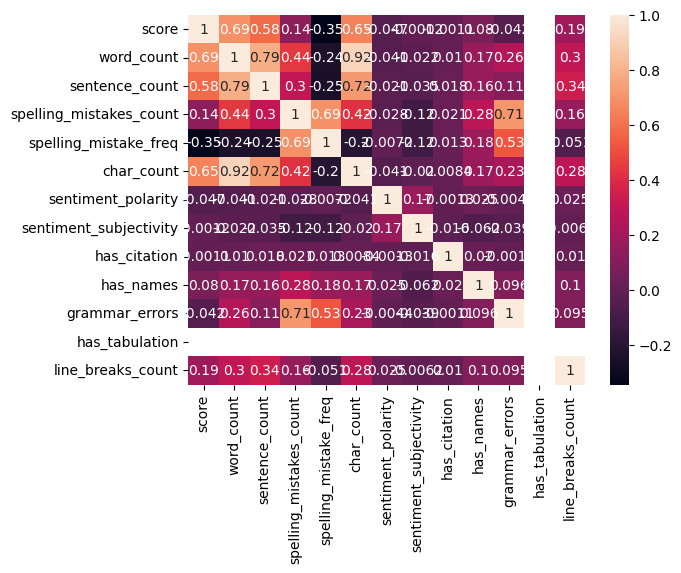

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df[['score', 
                  'word_count', 
                  'sentence_count', 
                  'spelling_mistakes_count', 
                  'spelling_mistake_freq', 
                  'char_count', 
                  'sentiment_polarity', 
                  'sentiment_subjectivity',
                  'has_citation',
                  'has_names',
                  'grammar_errors',
                  'has_tabulation',
                  'line_breaks_count'
                  ]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [59]:
df

,essay_id,full_text,score,no_punctuation_text,word_count,sentence_count,char_count,spelling_mistakes_count,spelling_mistake_freq,sentiment_polarity,sentiment_subjectivity,has_citation,has_names,grammar_errors,has_tabulation,line_breaks_count
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live The thing...,498,13,2677,31,0.062249,0.179020,0.542236,False,True,53,False,0
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...,332,21,1677,9,0.027108,0.101786,0.444643,False,False,23,False,8
2,001ab80,People always wish they had the same technolog...,4,People always wish they had the same technolog...,550,24,3083,8,0.014545,0.168435,0.451264,False,False,11,False,6
3,001bdc0,"We all heard about Venus, the planet without a...",4,We all heard about Venus the planet without al...,454,20,2709,13,0.028634,0.094291,0.555147,False,True,11,False,8
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,Dear State Senator\r\n\r\nThis is a letter to ...,373,15,2218,14,0.037534,0.170952,0.569127,False,False,19,False,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,the story The Challenge of Exploing Venus is...,155,9,860,13,0.083871,-0.022639,0.415472,False,False,21,False,4
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,Technology has changed a lot of ways that we l...,579,26,3364,19,0.032815,0.092325,0.521077,False,True,20,False,10
17304,fff016d,If you don't like sitting around all day than ...,2,If you dont like sitting around all day than i...,215,15,1126,4,0.018605,0.335317,0.481349,False,True,7,False,4
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,In The Challenge of Exporing Venus the author ...,230,11,1427,8,0.034783,0.133208,0.543756,False,True,9,False,0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['essay_id', 'full_text', 'no_punctuation_text', 'score']), df['score'], test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(f"Mean: {np.mean(y_pred == y_test)}")
kappa_score = quadratic_weighted_kappa(y_test, y_pred)
print(f"Quadratic Weighted Kappa: {kappa_score}")

Mean: 0.5866551126516465
Quadratic Weighted Kappa: 0.7149657470727016
